# <div style="text-align: center"> [Quora Question Pairs Competition on Kaggle](https://www.kaggle.com/c/quora-question-pairs/overview) </div> 
## Description
The goal of this competition is to predict which of the provided pairs of questions contain two questions with the same meaning.

### [Data Description](https://www.kaggle.com/c/quora-question-pairs/data) from [competition site](https://www.kaggle.com/c/quora-question-pairs/data):
The ground truth is the set of labels that have been supplied by human experts. The ground truth labels are inherently subjective, as the true meaning of sentences can never be known with certainty. Human labeling is also a 'noisy' process, and reasonable people will disagree. As a result, the ground truth labels on this dataset should be taken to be 'informed' but not 100% accurate, and may include incorrect labeling. We believe the labels, on the whole, to represent a reasonable consensus, but this may often not be true on a case by case basis for individual items in the dataset.

Please note: as an anti-cheating measure, Kaggle has supplemented the test set with computer-generated question pairs. Those rows do not come from Quora, and are not counted in the scoring. All of the questions in the training set are genuine examples from Quora.

### Data fields:
* `id` - the id of a training set question pair
* `qid1, qid2` - unique ids of each question (only available in train.csv)
* `question1, question2` - the full text of each question
* `is_duplicate` - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

## Approach:
The approach is explained in the following steps:
1. Exploratory Data Analysis
    - Basic exploration
    - Missing Values
    - Outliers
    - Univariate/Bivariate - if applicable
    - Feature normaliation
    - Feature Engineering
2. Text Analysis Steps [NLP]:
    - Text Processing
        - Normalization
            - To lower case
            - Remove punctuation
    - Tokenization
        - Convert it to words
    - Stopwords removal
    - Parts of Speech Tagging
    - Stemming or Lemmatization - choose one of them based on requirement. Sometimes, Lemmatization can take a long time to give results.
    - Named Entity recognition
2. Feature Creation
    - Create a feature that will indicate the percentage of words common between two questions
3. Based on the created feature, train our model to understand the relationship between target variable and the features.

Without further ado, let's start with importing data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df_train =  pd.read_csv('train.csv.zip')
df_train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


In [3]:
df_test = pd.read_csv('test.csv.zip',dtype ='object')
df_test.head(3)

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?


## 1. Exploratory Data Analysis

In [4]:
# Number of question pairs in train and test set
# Number of dupicate pairs in train
# Number of unique questions in the entire train dataset
# Number of duplicate questions in the entire dataset

print(f'shape of train:{df_train.shape}')
print(f'shape of test:{df_test.shape}')
print(f'number of pairs having same questions in train:{df_train.is_duplicate.sum()}')
print(f'number of pairs having different questions in train:{df_train.shape[0] - df_train.is_duplicate.sum()}')
all_questions_train = pd.concat([df_train['question1'],df_train['question2']], axis = 0)
all_questions_train = list(all_questions_train)
all_questions_test = pd.concat([df_test['question1'],df_test['question2']], axis = 0)
all_questions_test = list(all_questions_test)
print(f'total number of questions in train:{len(list(all_questions_train))}')
print(f'total number of questions in test:{len(list(all_questions_test))}')
print(f'total number of unique questions in train:{len(set(all_questions_train))}')
print(f'total number of unique questions in test:{len(set(all_questions_test))}')
print(f'total number of duplicate questions in train:{len(all_questions_train) - len(set(all_questions_train))}')
print(f'total number of duplicate questions in test:{len(all_questions_test) - len(set(all_questions_test))}')

shape of train:(404290, 6)
shape of test:(3563475, 3)
number of pairs having same questions in train:149263
number of pairs having different questions in train:255027
total number of questions in train:808580
total number of questions in test:7126950
total number of unique questions in train:537361
total number of unique questions in test:4363832
total number of duplicate questions in train:271219
total number of duplicate questions in test:2763118


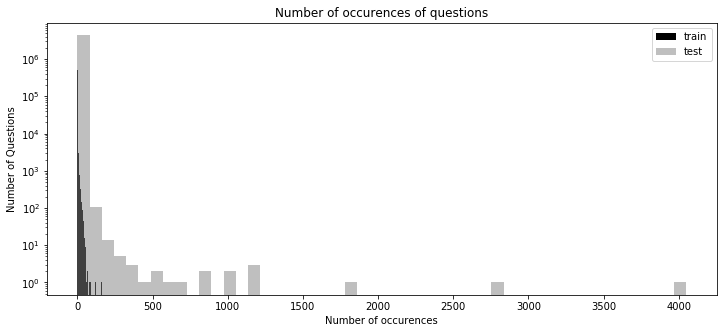

In [5]:
plt.figure(figsize =  (12,5))
plt.hist(pd.Series(all_questions_train).value_counts(), bins = 50, color = 'black', label = 'train')
plt.hist(pd.Series(all_questions_test).value_counts(), alpha = 0.5, bins = 50, color = 'gray', label = 'test')
plt.yscale('log')
plt.title('Number of occurences of questions')
plt.xlabel('Number of occurences')
plt.ylabel('Number of Questions')
plt.legend()

There is a large difference in distribution of train set and test set. This might be due to auto-generated questions. From the competition's description:

> As an anti-cheating measure, Kaggle has supplemented the test set with computer-generated question pairs. Those rows do not come from Quora, and are not counted in the scoring. All of the questions in the training set are genuine examples from Quora.

### Missing values

In [6]:
print(df_train.isna().sum())
print(df_test.isna().sum())

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64
test_id      0
question1    4
question2    6
dtype: int64


In [7]:
df_train[df_train['question1'].isna()|df_train['question2'].isna()]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [8]:
df_test[df_test['question1'].isna()|df_test['question2'].isna()]

,test_id,question1,question2
379205,379205,How I can learn android app development?,NaN
817520,817520,How real can learn android app development?,NaN
943911,943911,How app development?,NaN
1046690,1046690,NaN,How I what can learn android app development?
1270024,1270024,How I can learn app development?,NaN
1461432,1461432,NaN,How distinct can learn android app development?
2345796,"life in dublin?""",NaN,NaN
2487703,1270024,How I can learn app development?,NaN
2679111,1461432,NaN,How distinct can learn android app development?


One interresting thing to note here is that the train and test set both contains few null entries and the questions are all related when there is a null in the second question. In test set, we observe the same question repeating again and again as they are auto-generated with reordering of words.

Let's drop rows having missing values in train as they are very few. We can't drop rows in test set as we will lose test set ids and then we won't be able to submit our solution. Let's fill test set null with 'not available' for now.

In [9]:
df_train.dropna(inplace =True)
df_test.replace(np.nan, 'not available', inplace = True)

In [10]:
# Analyzing number of words
df_train['len_1'] = df_train['question1'].apply(lambda x: len(x.split()))
df_train['len_2'] = df_train['question2'].apply(lambda x: len(x.split()))

In [11]:
df_test['len_1'] = df_test['question1'].apply(lambda x: len(x.split()))
df_test['len_2'] = df_test['question2'].apply(lambda x: len(x.split()))

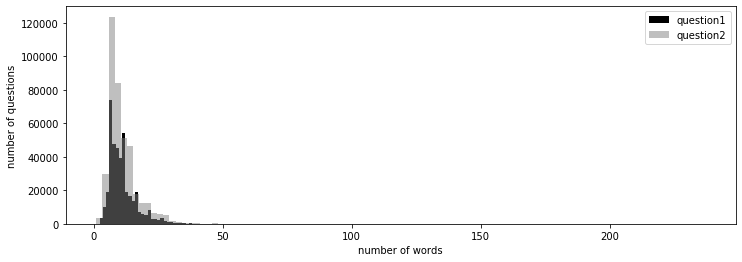

In [12]:
# plot words distribution for question 1 and question 2 in train set
plt.figure(figsize=(12,4))
plt.hist(df_train['len_1'], label = 'question1', color = 'black', bins = 100)
plt.hist(df_train['len_2'], label = 'question2', color = 'gray', alpha = 0.5, bins =100)
plt.xlabel('number of words')
plt.ylabel('number of questions')
# plt.xlim(0,150)
plt.legend()

Text(0, 0.5, 'min, median, max of number of words')

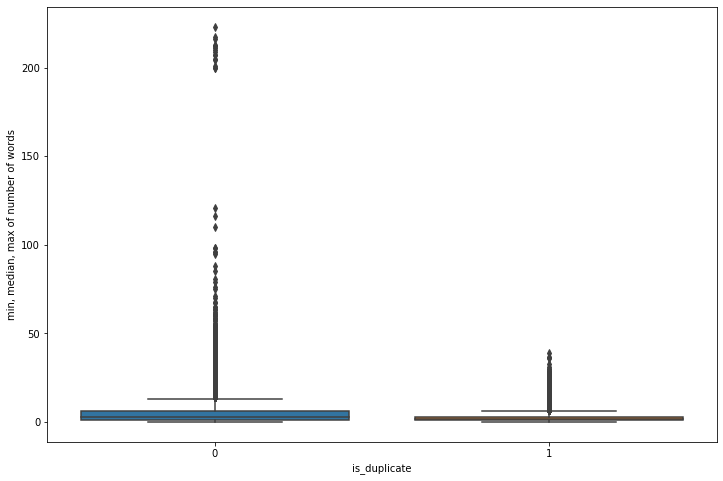

In [13]:
# Comparing differences in number of words between duplicate questions with that of unique questions
plt.figure(figsize = (12,8))
sns.boxplot(x = df_train['is_duplicate'], y = np.abs(df_train['len_1'] - df_train['len_2']) )
plt.xlabel('is_duplicate')
plt.ylabel('min, median, max of number of words')

From the plot on the left side, we can infer that the number of words are higly different if the qustions are not same. On the other hand, from the plot on right side, we can infer that the number of words in two questons which are same, are very close.

## 2. Text Analysis [Preliminary steps of Natural Language Processing]
   - Text Processing
        - Normalization
            - To lower case
            - Remove punctuation
   - Tokenization
        - Convert it to words
   - Stopwords removal
   - Parts of Speech Tagging
   - Stemming or Lemmatization - choose one of them based on requirement. Sometimes, Lemmatization can take a long time to give results.
   - Named Entity recognition

In [14]:
# Combine train and test questions only for cleaning purposes. After all the preprocessing, we will separate them
# into two sets
df_train['source'] = 'train'
df_test['source'] = 'test'
train_test = pd.concat([df_train, df_test], axis = 0)

In [15]:
# Uncomment the following piece of code and download punkt package if not present in your system
# import nltk
# nltk.download()

In [16]:
# Normalization
import string
punc = string.punctuation
train_test[['question1','question2']] =train_test[['question1','question2']].apply(lambda x: x.apply(lambda y: ''.join(char for char in y.lower() if char not in punc) ))

In [26]:
# Let's separate training and testing set
train = train_test.loc[train_test['source'] == 'train']
test = train_test.loc[train_test['source'] == 'test']
train.drop(['source','test_id'], axis = 1, inplace = True)
test.drop(['source','id', 'qid1','qid2','is_duplicate'], axis = 1, inplace = True)

## Text to Features (feature engineering on text data)
1. Initial Feature Analysis

In [31]:
from nltk.tokenize import word_tokenize
train[['question1','question2']] =train[['question1','question2']].apply(lambda x: x.apply(lambda y: word_tokenize(y)))

C:\Users\hp\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [32]:
from nltk.corpus import stopwords

# please note that converting stopwords to set is an important step as it increases efficiency. Otherwise it would take
# forever to remove the stopwords
stops = set(stopwords.words('english'))

# finding number of common words between question 1 and question 2 before removing stopwords
train['common_words_including_stopwords'] = train.apply(lambda x: len(set(x['question1']) & set(x['question2'])), axis = 1, raw  = True)
#removing stopwords
train['question1'] =train['question1'].apply(lambda y: [word for word in y if word not in stops])
train['question2'] =train['question2'].apply(lambda y: [word for word in y if word not in stops])

# finding number of common words between question 1 and question 2 after removing stpwords
train['common_words_excluding_stopwords'] = train.apply(lambda x: len(set(x['question1']) & set(x['question2'])), axis = 1, raw  = True)

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [33]:
train['len_1_without_stopwords'] = train['question1'].apply(lambda x: len(x))
train['len_2_without_stopwords'] = train['question2'].apply(lambda x: len(x))

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
# finding ratio of common words

# train_valid = train[(train['common_words_excluding_stopwords']!=0) & (train['common_words_including_stopwords']!=0)]

train['percent_with_stopwords'] = train.apply(lambda row: 0 if row['common_words_including_stopwords']==0 else 2*row['common_words_including_stopwords']/(row['len_1'] + row['len_2']) ,axis = 1, raw=  True)
train['percent_without_stopwords'] = train.apply(lambda row: 0 if row['common_words_excluding_stopwords']==0 else 2*row['common_words_excluding_stopwords']/(row['len_1_without_stopwords'] + row['len_2_without_stopwords']) ,axis = 1, raw=  True)

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


I believe that number of common words in a pair of questions should be highly correlated with 'is_duplicate' columns. If this is the case, then we will use this to predict whether two questions are duplicates and will also look at accuracy.

#### Correlation between a continuous and categorical variable:
Usually, if we have a categorical variable with only two classe, we can use df.corr() to get the correlation between categorical and continuous variables

In [35]:
train[['percent_with_stopwords','is_duplicate']].corr()

,percent_with_stopwords,is_duplicate
percent_with_stopwords,1.000000,0.372799
is_duplicate,0.372799,1.000000


In [36]:
train[['percent_without_stopwords','is_duplicate']].corr()

,percent_without_stopwords,is_duplicate
percent_without_stopwords,1.000000,0.426174
is_duplicate,0.426174,1.000000


Text(0, 0.5, 'distribution')

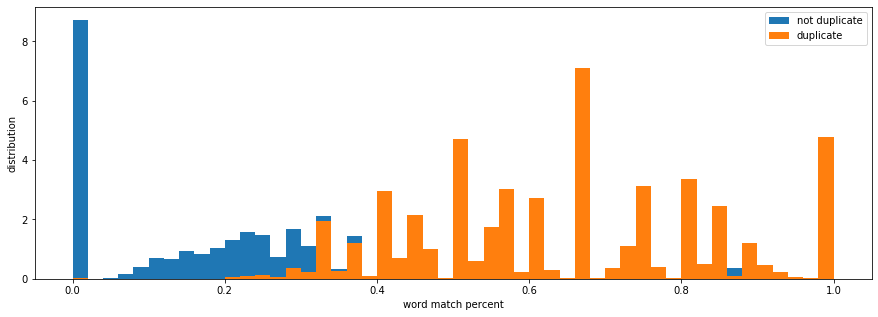

In [37]:
plt.figure(figsize=(15, 5))
plt.hist(train[train['is_duplicate']==0]['percent_without_stopwords'], bins = 50, density = True, label ='not duplicate')
plt.hist(train[train['is_duplicate']==1]['percent_without_stopwords'], bins = 50, density = True, label ='duplicate')
plt.legend()
plt.xlabel('word match percent')
plt.ylabel('distribution')

### Bingo!

As expected, duplicate pairs have more word matches as compared to non duplicate ones. We can use this new feature to predict the duplicates.
I am now going to improve this feature by using TF-IDF

In [88]:
# import CountVectorizer that will be used for creating count of each word in our corpus
from sklearn.feature_extraction.text import CountVectorizer
# our corpus is the collection of all 
corpus = all_questions_train
# make an instance of CountVectorizer object
vectorizer = CountVectorizer()
# Tokenize and build vocab
transformer = vectorizer.fit(all_questions)
# Understanding transformer
print(type(transformer.vocabulary_)) # tranformer.vocabulary_ is a dictionary with word as key and an id for that word as value

<class 'dict'>


In [89]:
print(len(transformer.vocabulary_))

86152


It means that there are 86152 words in this corpus

In [94]:
# Understanding transform with one example
q = all_questions_train[0] # q = 'What is the step by step guide to invest in share market in india?'
bow_one = transformer.transform([q])
print(bow_one.shape)
print(bow_one)

(1, 86152)
  (0, 14275)	1
  (0, 34358)	1
  (0, 38685)	2
  (0, 38956)	1
  (0, 40267)	1
  (0, 40578)	1
  (0, 47835)	1
  (0, 69173)	1
  (0, 72818)	2
  (0, 76374)	1
  (0, 77205)	1
  (0, 83238)	1


In [101]:
# printing few words to understand the meaning of above result
print(q)
print(str(transformer.get_feature_names()[14275]) + ' occurs 1 time')
print(str(transformer.get_feature_names()[38685]) +' and ' +str(transformer.get_feature_names()[72818]) + ' occur twice')

What is the step by step guide to invest in share market in india?
by occurs 1 time
in and step occur twice


It means that the transform method transforms the passed quantity (in this case, q) into a matrix having as many rows as the number of documents (in this case, 1) and having as many columns as the number of words in the corpus (in this case, 86152). The object bow_one is a sparse matrix where all the values are 0, except the one shown above. "(0,14275) 1" means that in the first document, the word mapped to 14275 has only 1 occurrence across the corpus (that is, the entire collection of questions). To understand it better please look at the following:

![bag_of_words](images/bag_of_words.png)

Since, there are so many words in the corpus, and only few words are present in a document, so this matrix will have many zeros. To utilise memory efficiently, sklearn stores it as [sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix).